# Predicting Water Pump Functionality in Tanzania

## Data Source 
The data for this comeptition comes from the Taarifa waterpoints dashboard, which aggregates data from the Tanzania Ministry of Water.

In their own words:

>Taarifa is an open source platform for the crowd sourced reporting and triaging of infrastructure related issues. Think of it as a bug tracker for the real world which helps to engage citizens with their local government. We are currently working on an Innovation Project in Tanzania, with various partners.

You can learn more here:
    [Taarifa Homepage](http://taarifa.org/)



## Pump it Up: Data Mining the Water Table

Challenge set by [Driven Data](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/)

Challenge Description: 

>Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.


# Getting the Data

In [113]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, RocCurveDisplay, roc_curve, auc

## Read and combine Dataframes

In [48]:
t_labels = pd.read_csv('Data/Training_Set_Labels.csv')
t_values = pd.read_csv('Data/Training_Set_Values.csv')

test_set = pd.read_csv('Data/Test_Set.csv')

In [49]:
#merge databases
water_pumps = t_labels.merge(t_values, on="id")

In [50]:
water_pumps['permit'] = water_pumps['permit'].astype(float)

In [51]:
water_pumps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   status_group           59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   date_recorded          59400 non-null  object 
 4   funder                 55763 non-null  object 
 5   gps_height             59400 non-null  int64  
 6   installer              55745 non-null  object 
 7   longitude              59400 non-null  float64
 8   latitude               59400 non-null  float64
 9   wpt_name               59398 non-null  object 
 10  num_private            59400 non-null  int64  
 11  basin                  59400 non-null  object 
 12  subvillage             59029 non-null  object 
 13  region                 59400 non-null  object 
 14  region_code            59400 non-null  int64  
 15  di

# Location and Status 

In [52]:
water_pumps.sample(10)

id             status_group  amount_tsh date_recorded  \
13518   5449               functional       300.0    2011-03-27   
34264  24267               functional      3000.0    2011-03-08   
22112  15564               functional       300.0    2011-03-02   
648    37750           non functional         0.0    2011-03-08   
25184  49539               functional         0.0    2011-03-19   
50963  15890           non functional         0.0    2012-10-03   
37092  62769           non functional         0.0    2011-03-07   
401    39915               functional        10.0    2013-03-19   
15103  35841           non functional         0.0    2004-12-01   
38448  32129  functional needs repair         0.0    2013-03-21   

                       funder  gps_height       installer  longitude  \
13518  Government Of Tanzania         406             DWE  38.342864   
34264                  Danida         859           DANID  35.362771   
22112                     Dhv         349             DWE  36.845272   
648                       Dct           0             DCT  35.893782   
25184                    Cmsr           0            CMSR  36.373899   
50963                   Rwssp           0           RWSSP  32.800324   
37092      Private Individual          42             DWE  38.931946   
401     Government/ Community         965  RWE/ Community  36.926935   
15103  Government Of Tanzania           0             RWE  31.757089   
38448                    Tcrs        1534            TCRS  37.939125   

       latitude       wpt_name  ...  payment_type water_quality quality_group  \
13518 -4.971077        Ngomeni  ...       monthly          soft          good   
34264 -7.630596           none  ...      annually          soft          good   
22112 -9.010422        Mtakuja  ...       monthly          soft          good   
648   -6.383478         Church  ...       unknown       unknown       unknown   
25184 -6.706434    Kwa Ngelula  ...       monthly          soft          good   
50963 -3.936368         Ujamaa  ...       unknown          soft          good   
37092 -5.510890       Kiamboni  ...     never pay          soft          good   
401   -3.465388       Elisante  ...    per bucket          soft          good   
15103 -1.044372      Kwantanda  ...     never pay          soft          good   
38448 -4.467380  Kwa Nathaniel  ...     never pay          soft          good   

           quantity  quantity_group        source   source_type source_class  \
13518        enough          enough  shallow well  shallow well  groundwater   
34264        enough          enough        spring        spring  groundwater   
22112        enough          enough  shallow well  shallow well  groundwater   
648             dry             dry  shallow well  shallow well  groundwater   
25184  insufficient    insufficient  shallow well  shallow well  groundwater   
50963        enough          enough  shallow well  shallow well  groundwater   
37092  insufficient    insufficient         river    river/lake      surface   
401          enough          enough        spring        spring  groundwater   
15103  insufficient    insufficient        spring        spring  groundwater   
38448        enough          enough        spring        spring  groundwater   

                   waterpoint_type waterpoint_type_group  
13518                    hand pump             hand pump  
34264           communal standpipe    communal standpipe  
22112                    hand pump             hand pump  
648                          other                 other  
25184                    hand pump             hand pump  
50963                        other                 other  
37092           communal standpipe    communal standpipe  
401    communal standpipe multiple    communal standpipe  
15103           communal standpipe    communal standpipe  
38448           communal standpipe    communal standpipe  

[10 rows x 41 columns]

In [61]:
fig = px.scatter_geo(water_pumps, 'latitude', 'longitude', hover_name='id', color='status_group', opacity=0.3)
fig.update_geos(showcountries =True, scope='africa', fitbounds="locations")

fig.show()


## There are pumps in the ocean, which does not make logical sense......

In [60]:
lat_0 = water_pumps.loc[water_pumps['longitude']== 0]
lat_0['region'].value_counts()

region
Shinyanga    1005
Mwanza        807
Name: count, dtype: int64

It looks as if they should be in these regions instead. 

In [65]:
water_pumps.loc[(water_pumps['longitude'] == 0) & (water_pumps['region'] == 'Shinyanga'), 'longitude'] = 32
water_pumps.loc[(water_pumps['longitude'] == 0) & (water_pumps['region'] == 'Mwanza'), 'longitude'] = 31

## Now we can examine via region. 

To make it easier, colors should be consistient. 

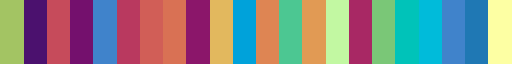

In [180]:
# Define a custom list of 21 colors
custom_colors = [
    '#a3c463', '#4b116e', '#c64b5b', '#74106d', '#4083cb', '#b9395f',
     '#d15e57', '#d97154', '#8b166a', '#e2b85e', '#00a2da',  '#de8553',  '#4cc792', '#e19a54',
    '#c2f8a2',  '#a82864',  '#7ac777', '#00c3b9',
    '#00bbda',  '#4083cb', '#1f78b4',
     '#fdffa3'
]

# Create a ListedColormap with the custom colors
custom_cmap = mcolors.ListedColormap(custom_colors)
custom_cmap

In [181]:
unique_regions = water_pumps['region'].unique()

# Generate the color mapping for each region
color_map = {region: color for region, color in zip(unique_regions, custom_colors)}
# Verify the color map
print(color_map)

water_pumps = water_pumps.sort_values(by='region')


{'Arusha': '#a3c463', 'Dar es Salaam': '#4b116e', 'Dodoma': '#c64b5b', 'Iringa': '#74106d', 'Kagera': '#4083cb', 'Kigoma': '#b9395f', 'Kilimanjaro': '#d15e57', 'Lindi': '#d97154', 'Manyara': '#8b166a', 'Mara': '#e2b85e', 'Mbeya': '#00a2da', 'Morogoro': '#de8553', 'Mtwara': '#4cc792', 'Mwanza': '#e19a54', 'Pwani': '#c2f8a2', 'Rukwa': '#a82864', 'Ruvuma': '#7ac777', 'Shinyanga': '#00c3b9', 'Singida': '#00bbda', 'Tabora': '#4083cb', 'Tanga': '#1f78b4'}


In [182]:
functional_pumps = water_pumps.loc[water_pumps['status_group']== 'functional']
fig = px.scatter_geo(functional_pumps, 'latitude', 'longitude', hover_name='id', color='region', color_discrete_map=color_map, opacity=0.3)
fig.update_geos(showcountries =True, scope='africa', fitbounds="locations")

fig.show()


In [183]:
non_functional_pumps = water_pumps.loc[water_pumps['status_group']== 'non functional']
fig = px.scatter_geo(non_functional_pumps, 'latitude', 'longitude', hover_name='id', color='region', color_discrete_map=color_map,  opacity=0.3)
fig.update_geos(showcountries =True, scope='africa', fitbounds="locations")

fig.show()

In [167]:
needs_repair = water_pumps.loc[water_pumps['status_group']== 'functional needs repair']
fig = px.scatter_geo(needs_repair, 'latitude', 'longitude', hover_name='id',color='region', color_discrete_map=color_map, opacity=0.3)
fig.update_geos(showcountries =True, scope='africa', fitbounds="locations")

fig.show()

## Are specific regions being underserviced? 

In [ ]:
region_grouped

# One Hot Encoding

In [7]:
#add renamed OHE columns to water_pumps. 
def add_OHE_cols(transformed_df): 
    '''
    Add columns to Water_Pumps
    '''
    for col in transformed_df.columns:
        if col.__contains__('onehotencoder'):
            col_name = col.replace('onehotencoder__', '')
            col_name = col_name.replace(' ', '_')
            water_pumps[col_name] = transformed_df[col].astype(float)

### Pump Status

In [8]:

#add groups to our dataframe 
transformer = make_column_transformer(
    (OneHotEncoder(), ['status_group']),
    remainder='passthrough')

transformed = transformer.fit_transform(water_pumps)
transformed_df = pd.DataFrame(
    transformed, 
    columns=transformer.get_feature_names_out()
)


In [9]:
#add columns to main dataframe
add_OHE_cols(transformed_df)

### Management Group

In [10]:
#categorical data
categorical_cols = ['funder', 'funder', 'installer', 'management_group', 'quality_group', 'waterpoint_type_group']

#add groups to our dataframe 
transformer = make_column_transformer(
    (OneHotEncoder(), ['management_group']),
    remainder='passthrough')

transformed = transformer.fit_transform(water_pumps)
transformed_df = pd.DataFrame(
    transformed, 
    columns=transformer.get_feature_names_out()
)


In [11]:
#add columns to main dataframe
add_OHE_cols(transformed_df)

### Quality Group

In [12]:
#add groups to our dataframe 
transformer = make_column_transformer(
    (OneHotEncoder(), ['quality_group']),
    remainder='passthrough')

transformed = transformer.fit_transform(water_pumps)
transformed_df = pd.DataFrame(
    transformed, 
    columns=transformer.get_feature_names_out()
)

In [13]:
#add columns to main dataframe
add_OHE_cols(transformed_df)

### Basin

In [14]:
#add groups to our dataframe 
transformer = make_column_transformer(
    (OneHotEncoder(), ['basin']),
    remainder='passthrough')

transformed = transformer.fit_transform(water_pumps)
transformed_df = pd.DataFrame(
    transformed, 
    columns=transformer.get_feature_names_out()
)

In [15]:
#add columns to main dataframe
add_OHE_cols(transformed_df)

## Examine Correlations 

                                      amount_tsh  num_private  region_code  \
amount_tsh                              1.000000     0.002944    -0.026813   
num_private                             0.002944     1.000000    -0.020377   
region_code                            -0.026813    -0.020377     1.000000   
district_code                          -0.023599    -0.004478     0.678602   
population                              0.016288     0.003818     0.094088   
permit                                  0.028188     0.009931    -0.029070   
construction_year                       0.067915     0.026056     0.031724   
status_group_functional                 0.052427     0.005780    -0.104178   
status_group_functional_needs_repair   -0.004724    -0.003810     0.002333   
status_group_non_functional            -0.051170    -0.003886     0.105444   
management_group_commercial            -0.002147     0.038651    -0.040282   
management_group_other                 -0.011005    -0.004922   

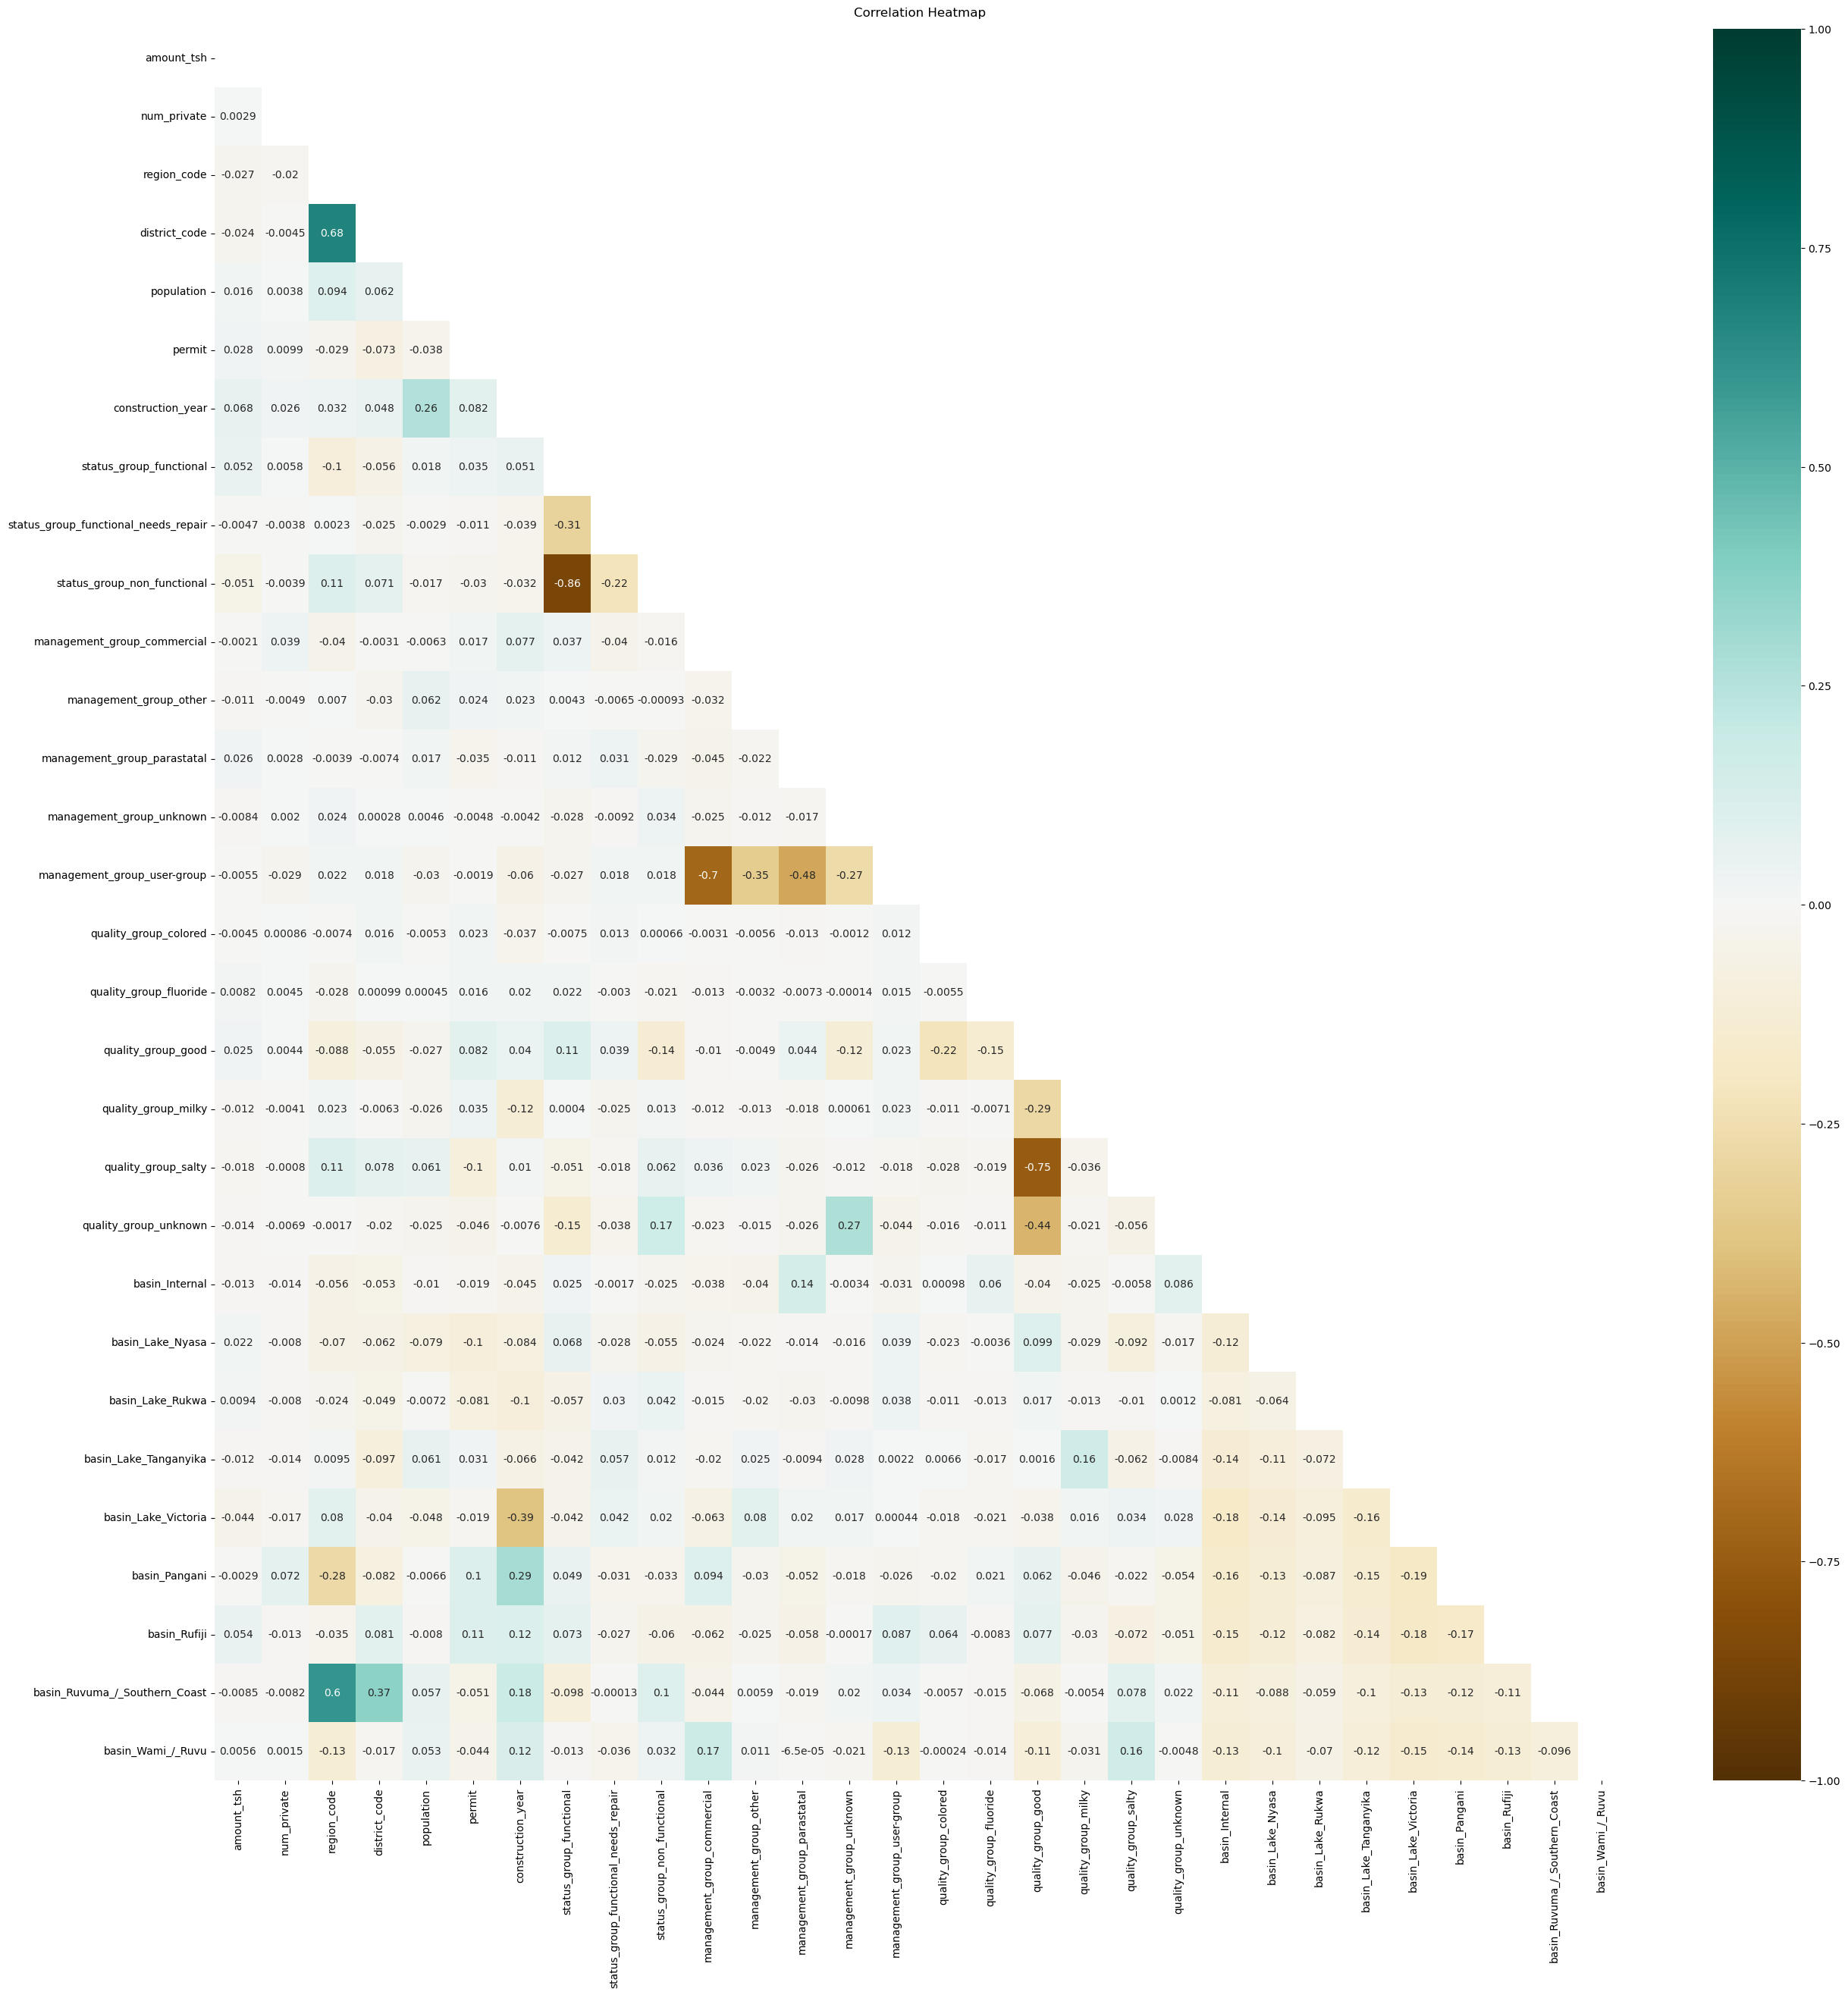

In [16]:
matrix = water_pumps.drop(columns=['id', 'gps_height', 'longitude', 'latitude', ])
matrix = matrix.corr(numeric_only=True)
print(matrix)

plt.figure(figsize=(30, 30))

#create a mask to remove the duplicate upper half
mask = np.triu(np.ones_like(matrix, dtype=np.bool))

heatmap = sns.heatmap(matrix, vmin=-1, mask=mask, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

# Decsicion Tree 

In [17]:
X = water_pumps.select_dtypes(exclude=['object'])
X = X.drop(columns=['status_group_functional', 'status_group_non_functional', 'status_group_functional_needs_repair'])
y = water_pumps['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

X_train.shape, X_test.shape

((47520, 31), (11880, 31))

In [18]:
tree_clf = DecisionTreeClassifier(random_state=1, min_samples_leaf=3712)

tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=3712, random_state=1)

In [19]:
y_pred = tree_clf.predict(X_test)
y_pred

array(['non functional', 'functional', 'functional', ...,
       'non functional', 'functional', 'functional'], dtype=object)

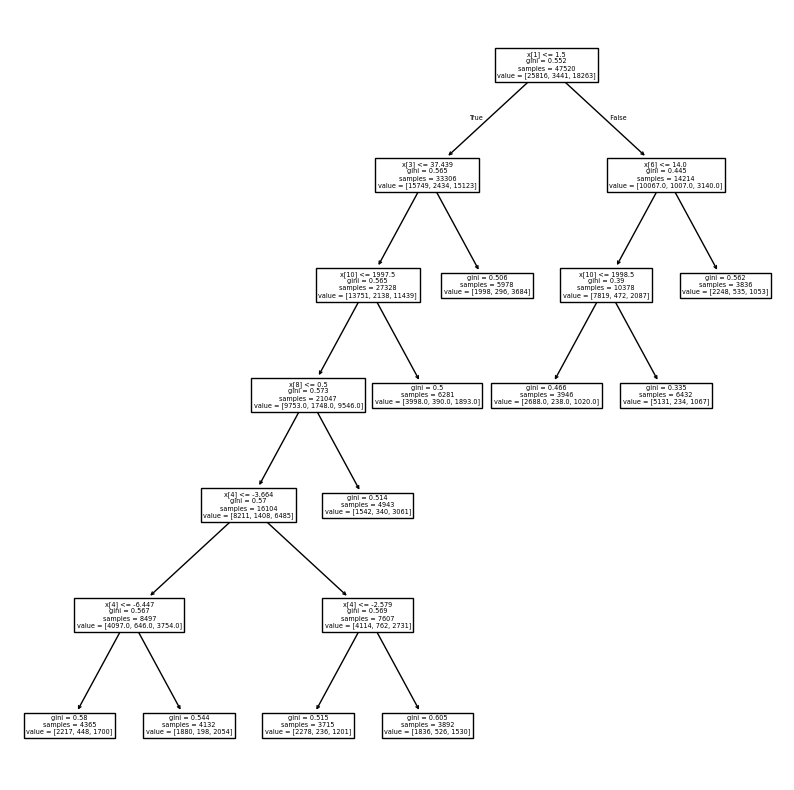

In [20]:
f, ax = plt.subplots(figsize=(10, 10))
plot_tree(tree_clf, ax=ax);

In [21]:
print('Training:', tree_clf.score(X_train, y_train))
print('Testing:', tree_clf.score(X_test, y_test))

Training: 0.6143728956228957
Testing: 0.613973063973064


In [22]:
feature_used = X.columns

for fi, feature in zip(tree_clf.feature_importances_, feature_used):
    print(fi, feature)


0.0 id
0.46999743366546826 amount_tsh
0.0 gps_height
0.1442918316072851 longitude
0.059135347898898266 latitude
0.0 num_private
0.050847078393754325 region_code
0.0 district_code
0.14046953700085518 population
0.0 permit
0.13525877143373874 construction_year
0.0 management_group_commercial
0.0 management_group_other
0.0 management_group_parastatal
0.0 management_group_unknown
0.0 management_group_user-group
0.0 quality_group_colored
0.0 quality_group_fluoride
0.0 quality_group_good
0.0 quality_group_milky
0.0 quality_group_salty
0.0 quality_group_unknown
0.0 basin_Internal
0.0 basin_Lake_Nyasa
0.0 basin_Lake_Rukwa
0.0 basin_Lake_Tanganyika
0.0 basin_Lake_Victoria
0.0 basin_Pangani
0.0 basin_Rufiji
0.0 basin_Ruvuma_/_Southern_Coast
0.0 basin_Wami_/_Ruvu
